=== Data Preprocessing ===
Original dataset shape: (7575, 10)
Missing values per column:
Unnamed: 0            0
name                  0
year_published        0
min_age               0
best_category_rank    0
popularity            0
adjusted_rating       0
adjusted_weight       0
average_players       0
time_per_player       4
dtype: int64
Using features: ['year_published', 'min_age', 'popularity', 'best_category_rank', 'adjusted_weight', 'average_players', 'time_per_player']

=== Outlier Detection ===
year_published: 464 outliers detected
min_age: 501 outliers detected
popularity: 133 outliers detected
best_category_rank: 0 outliers detected
adjusted_weight: 1138 outliers detected
average_players: 258 outliers detected
time_per_player: 792 outliers detected

Final dataset shape: X=(7575, 7), y=(7575,)
Target variable statistics:
count    7575.000000
mean        6.745609
std         0.279165
min         4.175224
25%         6.640327
50%         6.689064
75%         6.777263
max        

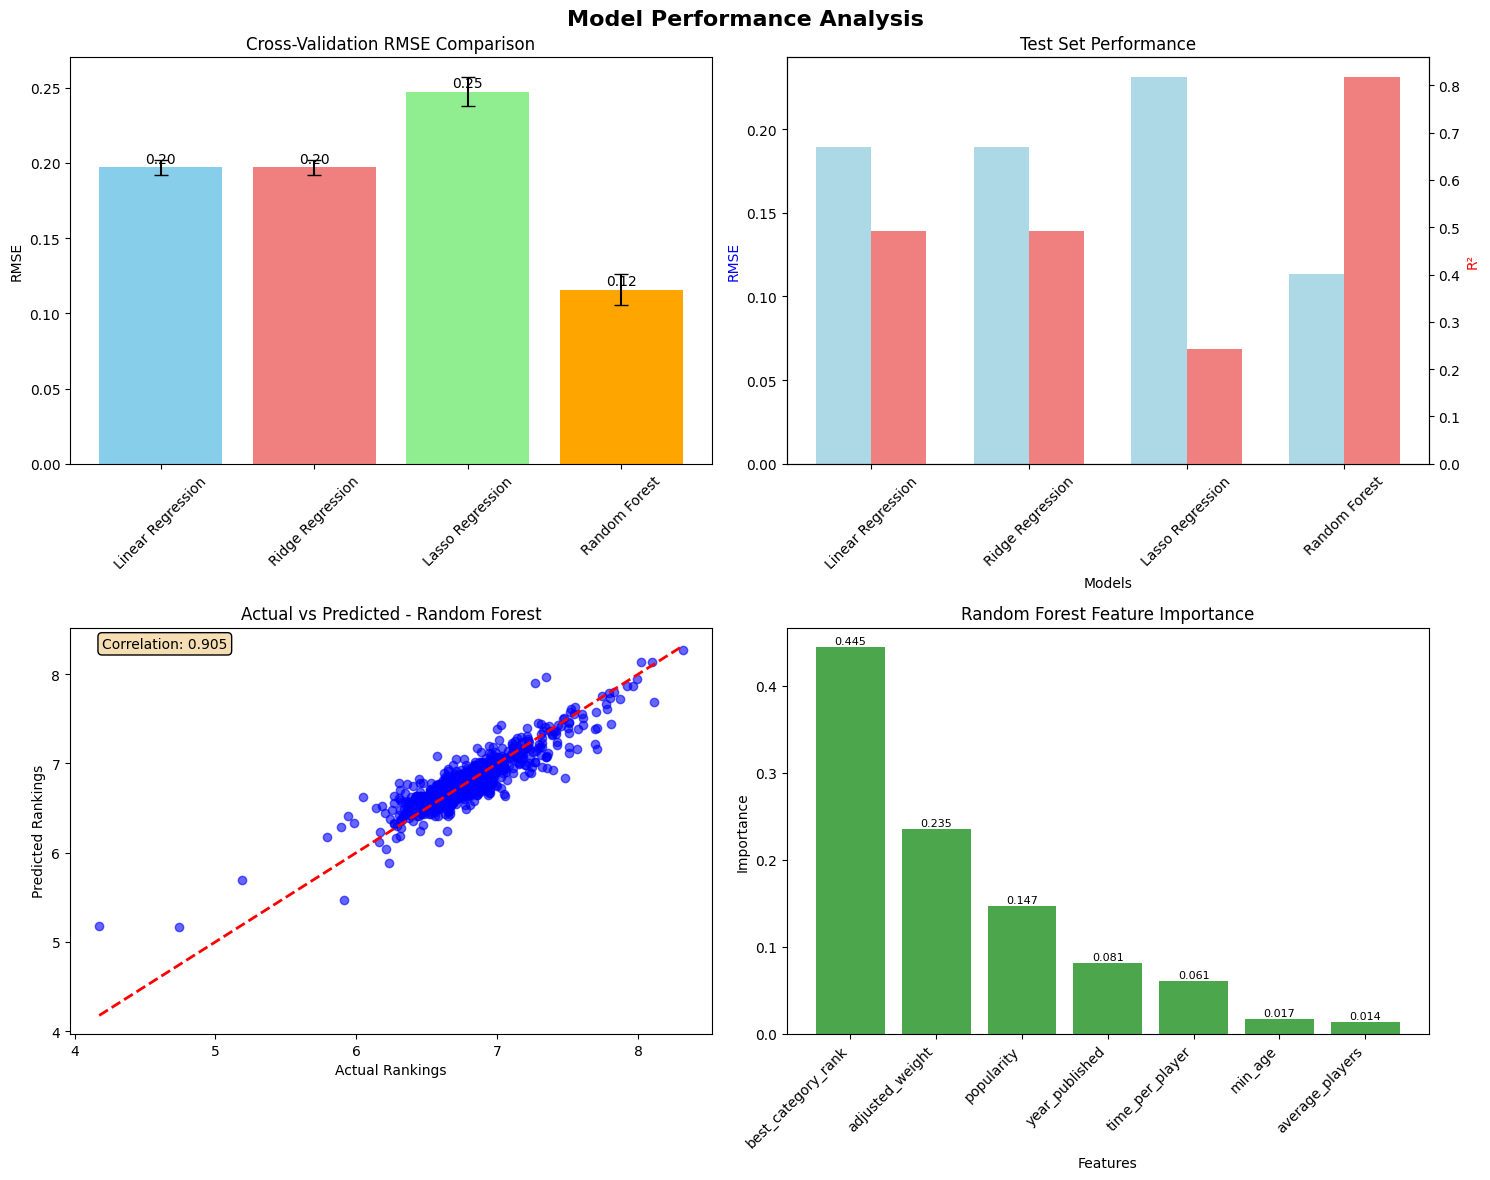


           BOARD GAME RANKING PREDICTION REPORT

Dataset Overview:
- Total samples: 7575
- Features used: 7
- Feature names: year_published, min_age, popularity, best_category_rank, adjusted_weight, average_players, time_per_player
- Target variable: adjusted_ranking
- Target range: 4 - 9

Data Split:
- Training set: 4545 samples
- Validation set: 1515 samples
- Test set: 1515 samples

Model Performance Summary:
Model                CV RMSE      Test RMSE    Test R²    Test MAPE   
------------------------------------------------------------------
Linear Regression    0.197        0.190        0.492      1.91        %
Ridge Regression     0.197        0.190        0.492      1.91        %
Lasso Regression     0.248        0.231        0.244      2.09        %
Random Forest        0.116        0.113        0.818      1.01        %

Best performing model: Random Forest
- Test R²: 0.818
- Test RMSE: 0.113



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class BoardGameRankingPredictor:
    def __init__(self, data_path=None, df=None):
        """
        Initialize the predictor with either a file path or DataFrame
        """
        if df is not None:
            self.df = df.copy()
        elif data_path is not None:
            self.df = pd.read_csv(data_path)
        else:
            raise ValueError("Either data_path or df must be provided")
        
        self.scaler = StandardScaler()
        self.models = {}
        self.results = {}
        
    def preprocess_data(self, target_column='adjusted_rating'):
        """
        Preprocess the data and prepare features
        """
        print("=== Data Preprocessing ===")
        print(f"Original dataset shape: {self.df.shape}")
        
        # Handle missing values
        print(f"Missing values per column:\n{self.df.isnull().sum()}")
        
        # Fill missing values with median for numeric columns
        numeric_columns = self.df.select_dtypes(include=[np.number]).columns
        for col in numeric_columns:
            if self.df[col].isnull().sum() > 0:
                self.df[col].fillna(self.df[col].median(), inplace=True)
        
        # Remove non-numeric columns except target
        feature_columns = ['year_published', 'min_age', 'popularity', 'best_category_rank', 
                          'adjusted_weight', 'average_players', 'time_per_player']
        
        # Check which columns exist in the dataset
        available_features = [col for col in feature_columns if col in self.df.columns]
        missing_features = [col for col in feature_columns if col not in self.df.columns]
        
        if missing_features:
            print(f"Warning: Missing features: {missing_features}")
        
        print(f"Using features: {available_features}")
        
        # Prepare X and y
        X = self.df[available_features]
        y = self.df[target_column]
        
        # Handle outliers using IQR method
        print("\n=== Outlier Detection ===")
        for col in X.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = ((X[col] < lower_bound) | (X[col] > upper_bound)).sum()
            print(f"{col}: {outliers} outliers detected")
        
        # Store processed data
        self.X = X
        self.y = y
        self.feature_names = available_features
        
        print(f"\nFinal dataset shape: X={X.shape}, y={y.shape}")
        print(f"Target variable statistics:\n{y.describe()}")
        
        return X, y
    
    def split_data(self, test_size=0.2, val_size=0.2, random_state=42):
        """
        Split data into train, validation, and test sets
        """
        print("\n=== Data Splitting ===")
        
        # First split: separate test set
        X_temp, X_test, y_temp, y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state, stratify=None
        )
        
        # Second split: separate train and validation from remaining data
        val_size_adjusted = val_size / (1 - test_size)  # Adjust validation size
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_adjusted, random_state=random_state
        )
        
        print(f"Train set: {X_train.shape[0]} samples ({X_train.shape[0]/len(self.X)*100:.1f}%)")
        print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(self.X)*100:.1f}%)")
        print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(self.X)*100:.1f}%)")
        
        # Scale the features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Store the splits
        self.X_train, self.X_val, self.X_test = X_train_scaled, X_val_scaled, X_test_scaled
        self.y_train, self.y_val, self.y_test = y_train, y_val, y_test
        self.X_train_raw, self.X_val_raw, self.X_test_raw = X_train, X_val, X_test
        
        return (X_train_scaled, X_val_scaled, X_test_scaled), (y_train, y_val, y_test)
    
    def train_models(self, cv_folds=5):
        """
        Train multiple regression models with cross-validation
        """
        print("\n=== Model Training with Cross-Validation ===")
        
        # Define models to train
        models_to_train = {
            'Linear Regression': LinearRegression(),
            'Ridge Regression': Ridge(),
            'Lasso Regression': Lasso(),
            'Random Forest': RandomForestRegressor(random_state=42)
        }
        
        # Hyperparameter grids for grid search
        param_grids = {
            'Linear Regression': {},
            'Ridge Regression': {'alpha': [0.1, 1.0, 10.0, 100.0]},
            'Lasso Regression': {'alpha': [0.1, 1.0, 10.0, 100.0]},
            'Random Forest': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5, 10]
            }
        }
        
        cv_results = {}
        
        for name, model in models_to_train.items():
            print(f"\nTraining {name}...")
            
            if param_grids[name]:  # If hyperparameters to tune
                grid_search = GridSearchCV(
                    model, param_grids[name], cv=cv_folds, 
                    scoring='neg_mean_squared_error', n_jobs=-1
                )
                grid_search.fit(self.X_train, self.y_train)
                best_model = grid_search.best_estimator_
                print(f"Best parameters: {grid_search.best_params_}")
            else:
                best_model = model
                best_model.fit(self.X_train, self.y_train)
            
            # Cross-validation scores
            cv_scores = cross_val_score(
                best_model, self.X_train, self.y_train, 
                cv=cv_folds, scoring='neg_mean_squared_error'
            )
            cv_rmse = np.sqrt(-cv_scores)
            
            # Validation set performance
            val_pred = best_model.predict(self.X_val)
            val_rmse = np.sqrt(mean_squared_error(self.y_val, val_pred))
            val_mae = mean_absolute_error(self.y_val, val_pred)
            val_r2 = r2_score(self.y_val, val_pred)
            
            # Store results
            cv_results[name] = {
                'model': best_model,
                'cv_rmse_mean': cv_rmse.mean(),
                'cv_rmse_std': cv_rmse.std(),
                'val_rmse': val_rmse,
                'val_mae': val_mae,
                'val_r2': val_r2,
                'val_predictions': val_pred
            }
            
            print(f"CV RMSE: {cv_rmse.mean():.3f} (±{cv_rmse.std():.3f})")
            print(f"Validation RMSE: {val_rmse:.3f}")
            print(f"Validation R²: {val_r2:.3f}")
        
        self.cv_results = cv_results
        return cv_results
    
    def evaluate_on_test_set(self):
        """
        Evaluate all trained models on the test set
        """
        print("\n=== Test Set Evaluation ===")
        
        test_results = {}
        
        for name, result in self.cv_results.items():
            model = result['model']
            
            # Make predictions on test set
            test_pred = model.predict(self.X_test)
            
            # Calculate metrics
            test_rmse = np.sqrt(mean_squared_error(self.y_test, test_pred))
            test_mae = mean_absolute_error(self.y_test, test_pred)
            test_r2 = r2_score(self.y_test, test_pred)
            test_mape = np.mean(np.abs((self.y_test - test_pred) / self.y_test)) * 100
            
            test_results[name] = {
                'rmse': test_rmse,
                'mae': test_mae,
                'r2': test_r2,
                'mape': test_mape,
                'predictions': test_pred
            }
            
            print(f"\n{name} Test Results:")
            print(f"  RMSE: {test_rmse:.3f}")
            print(f"  MAE: {test_mae:.3f}")
            print(f"  R²: {test_r2:.3f}")
            print(f"  MAPE: {test_mape:.2f}%")
        
        self.test_results = test_results
        return test_results
    
    def plot_results(self):
        """
        Create visualizations of model performance
        """
        print("\n=== Creating Visualizations ===")
        
        # Set up the plotting style
        plt.style.use('default')
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold')
        
        # 1. Cross-validation RMSE comparison
        ax1 = axes[0, 0]
        models = list(self.cv_results.keys())
        cv_means = [self.cv_results[m]['cv_rmse_mean'] for m in models]
        cv_stds = [self.cv_results[m]['cv_rmse_std'] for m in models]
        
        bars = ax1.bar(models, cv_means, yerr=cv_stds, capsize=5, 
                       color=['skyblue', 'lightcoral', 'lightgreen', 'orange'])
        ax1.set_title('Cross-Validation RMSE Comparison')
        ax1.set_ylabel('RMSE')
        ax1.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar, mean_val in zip(bars, cv_means):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(cv_stds)/10,
                    f'{mean_val:.2f}', ha='center', va='bottom')
        
        # 2. Test set metrics comparison
        ax2 = axes[0, 1]
        test_rmse = [self.test_results[m]['rmse'] for m in models]
        test_r2 = [self.test_results[m]['r2'] for m in models]
        
        x = np.arange(len(models))
        width = 0.35
        
        bars1 = ax2.bar(x - width/2, test_rmse, width, label='RMSE', color='lightblue')
        ax2_twin = ax2.twinx()
        bars2 = ax2_twin.bar(x + width/2, test_r2, width, label='R²', color='lightcoral')
        
        ax2.set_xlabel('Models')
        ax2.set_ylabel('RMSE', color='blue')
        ax2_twin.set_ylabel('R²', color='red')
        ax2.set_title('Test Set Performance')
        ax2.set_xticks(x)
        ax2.set_xticklabels(models, rotation=45)
        
        # 3. Actual vs Predicted for best model (highest R²)
        ax3 = axes[1, 0]
        best_model_name = max(self.test_results.keys(), 
                             key=lambda x: self.test_results[x]['r2'])
        best_predictions = self.test_results[best_model_name]['predictions']
        
        ax3.scatter(self.y_test, best_predictions, alpha=0.6, color='blue')
        
        # Perfect prediction line
        min_val = min(min(self.y_test), min(best_predictions))
        max_val = max(max(self.y_test), max(best_predictions))
        ax3.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        
        ax3.set_xlabel('Actual Rankings')
        ax3.set_ylabel('Predicted Rankings')
        ax3.set_title(f'Actual vs Predicted - {best_model_name}')
        
        # Add correlation coefficient
        correlation = np.corrcoef(self.y_test, best_predictions)[0, 1]
        ax3.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                transform=ax3.transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))
        
        # 4. Feature importance for Random Forest
        ax4 = axes[1, 1]
        if 'Random Forest' in self.cv_results:
            rf_model = self.cv_results['Random Forest']['model']
            importances = rf_model.feature_importances_
            feature_names = self.feature_names
            
            # Sort features by importance
            indices = np.argsort(importances)[::-1]
            
            bars = ax4.bar(range(len(importances)), importances[indices], 
                          color='green', alpha=0.7)
            ax4.set_title('Random Forest Feature Importance')
            ax4.set_xlabel('Features')
            ax4.set_ylabel('Importance')
            ax4.set_xticks(range(len(importances)))
            ax4.set_xticklabels([feature_names[i] for i in indices], rotation=45, ha='right')
            
            # Add value labels
            for i, bar in enumerate(bars):
                ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                        f'{importances[indices[i]]:.3f}', ha='center', va='bottom', fontsize=8)
        else:
            ax4.text(0.5, 0.5, 'Random Forest not available', 
                    ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('Feature Importance Not Available')
        
        plt.tight_layout()
        plt.show()
    
    def generate_summary_report(self):
        """
        Generate a comprehensive summary report
        """
        print(f"\nDataset Overview:")
        print(f"- Total samples: {len(self.df)}")
        print(f"- Features used: {len(self.feature_names)}")
        print(f"- Feature names: {', '.join(self.feature_names)}")
        print(f"- Target variable: adjusted_ranking")
        print(f"- Target range: {self.y.min():.0f} - {self.y.max():.0f}")
        
        print(f"\nData Split:")
        print(f"- Training set: {len(self.y_train)} samples")
        print(f"- Validation set: {len(self.y_val)} samples") 
        print(f"- Test set: {len(self.y_test)} samples")
        
        print(f"\nModel Performance Summary:")
        print(f"{'Model':<20} {'CV RMSE':<12} {'Test RMSE':<12} {'Test R²':<10} {'Test MAPE':<12}")
        print("-" * 66)
        
        for name in self.cv_results.keys():
            cv_rmse = self.cv_results[name]['cv_rmse_mean']
            test_rmse = self.test_results[name]['rmse']
            test_r2 = self.test_results[name]['r2']
            test_mape = self.test_results[name]['mape']
            
            print(f"{name:<20} {cv_rmse:<12.3f} {test_rmse:<12.3f} {test_r2:<10.3f} {test_mape:<12.2f}%")
        
        # Best model
        best_model_name = max(self.test_results.keys(), 
                             key=lambda x: self.test_results[x]['r2'])
        print(f"\nBest performing model: {best_model_name}")
        print(f"- Test R²: {self.test_results[best_model_name]['r2']:.3f}")
        print(f"- Test RMSE: {self.test_results[best_model_name]['rmse']:.3f}")
        
        print("\n" + "="*60)

# Usage example with your data
if __name__ == "__main__":
    predictor = BoardGameRankingPredictor(data_path='preprocessed_bgg_dataset.csv')
    
    # Run the complete pipeline
    X, y = predictor.preprocess_data()
    (X_train, X_val, X_test), (y_train, y_val, y_test) = predictor.split_data()
    cv_results = predictor.train_models()
    test_results = predictor.evaluate_on_test_set()
    predictor.plot_results()
    predictor.generate_summary_report()